In [150]:
!pip install import_ipynb
!pip install dtw-python

In [151]:
# Initial Setting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import import_ipynb
import Function
from dtw import *
from pykrx import stock
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.datasets.samples_generator import make_blobs

In [152]:
kospi_200 = stock.get_index_portfolio_deposit_file("1028")

In [153]:
df = pd.DataFrame(columns=['시가', '고가', '저가', '종가', '거래량', '종목명', '종목코드'])
for i in kospi_200:
    tmp_df = stock.get_market_ohlcv_by_date("20200101", "20210101", i, "y")
    name = stock.get_market_ticker_name(i)
    tmp_df['종목명'] = name
    tmp_df['종목코드'] = i
    df = df.append(tmp_df)

거래량 순으로 정렬:

In [154]:
sorted_df = df.sort_values(by=['거래량'], axis=0, ascending = False)
print(sorted_df.head(100))
code_df = sorted_df.iloc[:100, 6]

                시가      고가      저가      종가           거래량      종목명    종목코드
2020-12-31   55500   81300   42300   81000  5.471749e+09     삼성전자  005930
2020-12-31    3305    7980    2920    4695  3.397658e+09    남선알미늄  008350
2020-12-31    7270    7930    3070    7040  2.263565e+09    삼성중공업  010140
2020-12-31    5550   10550    2500    7920  2.128066e+09  두산인프라코어  042670
2020-12-31    7330  214000       0  124000  2.036548e+09     신풍제약  019170
...            ...     ...     ...     ...           ...      ...     ...
2020-12-31   37518   89260   18587   76100  1.013712e+08   한미사이언스  008930
2020-12-31  262500  332000  102500  240500  1.008337e+08       SK  034730
2020-12-31  254500  263000  126000  255500  9.882598e+07    현대모비스  012330
2020-12-31  236000  285000  133000  272000  9.843052e+07    POSCO  005490
2020-12-31   74100   97700   44600   87500  9.721405e+07       LG  003550

[100 rows x 7 columns]


In [155]:
def volume_ret_df(date_1, date_2, date_3, date_4):
    code_list = []
    name_list = []
    f_list = []
    o_list = []
    p_list = []
    for i in range(len(code_df)):
        code_tmp = code_df[i]
        name_tmp = stock.get_market_ticker_name(code_tmp)
        volume_df = stock.get_market_trading_volume_by_date(date_1, date_2, code_tmp)
        code_list.append(code_tmp)
        name_list.append(name_tmp)
        f_list.append(volume_df['외국인합계'].sum())
        o_list.append(volume_df['기관합계'].sum())
        p_list.append(volume_df['개인'].sum())
    result_df = pd.DataFrame(columns=['종목코드', '종목명', '외국인거래량', '기관거래량', '개인거래량', '수익률'])
    result_df['종목코드'] = code_list
    result_df['종목명'] = name_list
    result_df['외국인거래량'] = f_list
    result_df['기관거래량'] = o_list
    result_df['개인거래량'] = p_list
    ret_list = []
    for i in range(len(code_df)):
        code_tmp = code_df[i]
        tmp_df = stock.get_market_ohlcv_by_date(date_3, date_4, code_tmp)
        ret_tmp = (tmp_df.iloc[4, 3] / tmp_df.iloc[0, 0] - 1) * 100
        ret_list.append(ret_tmp)
    result_df['수익률'] = ret_list
    return result_df

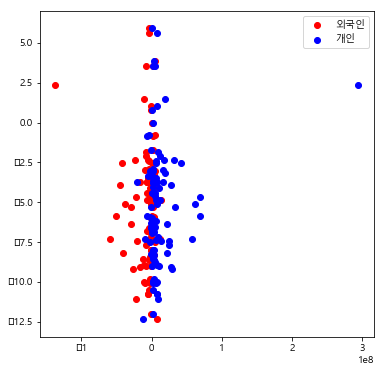

In [156]:
a_df = volume_ret_df("20200101", "20210131", "20200101", "20210131")
plt.figure(figsize = (6, 6))
plt.scatter(a_df['외국인거래량'], a_df['수익률'], c = 'r', label = '외국인')
plt.scatter(a_df['개인거래량'], a_df['수익률'], c = 'b', label = '개인')

plt.legend()
plt.show()

In [157]:
biases = np.ones((100, 1))

label_a = np.zeros((100, 1))
label_b = np.ones((100, 1))
y_tmp = a_df['수익률']
x1_tmp = a_df['외국인거래량']
x2_tmp = a_df['개인거래량']

y = y_tmp.values.reshape(-1, 1)
x1 = x1_tmp.values.reshape(-1, 1)
x2 = x2_tmp.values.reshape(-1, 1)

b_x1 = list(zip(biases, x1))
b_x1_tmp = np.array(b_x1)
b_x1_rs = b_x1_tmp.reshape(-1, 2)
p = np.hstack((b_x1_rs, y))
dataset_a = np.hstack((p,label_a))

b_x2 = list(zip(biases, x2))
b_x2_tmp = np.array(b_x2)
b_x2_rs = b_x2_tmp.reshape(-1, 2)
q = np.hstack((b_x2_rs, y))
dataset_b = np.hstack((q,label_b))

dataset = np.vstack((dataset_a, dataset_b))

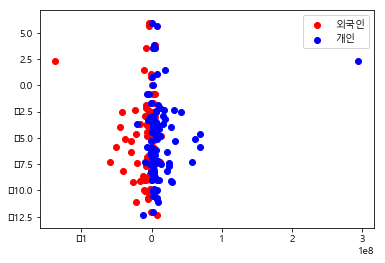

In [158]:
plt.scatter(dataset[:, 1][:100], dataset[:, 2][:100], c = 'r', label='외국인')
plt.scatter(dataset[:, 1][100:], dataset[:, 2][100:], c = 'b', label='개인')

plt.legend()
plt.show()

In [159]:
np.random.shuffle(dataset)

split_ratio = 0.7

train = dataset[0:int(split_ratio * 200)]
test = dataset[int(split_ratio * 200):200]

x_train = train[:, 0:3]
y_train = train[:, 3]

x_test = test[:, 0:3]
y_test = test[:, 3]

print(x_train[0])

[ 1.00000000e+00 -8.04976700e+06 -1.86028645e+00]


In [160]:
def train_perceptron(w, x, y, epoch=30):
    w = np.zeros(len(x[0]))
    for i in range(epoch):
        for j in range(len(y)):
            output = np.dot(x[j][1:], w[1:]) + w[0]
            tmp = np.where(output > 0 , 1, 0)
            update = 0.01 * (y[j] - tmp)
            w[1] += update * x[j][1]
            w[2] += update * x[j][2]
            w[0] += update
    return w

def x2(x1, w):
    w0 = w[0]
    w1 = w[1]
    w2 = w[2]
    x2 = []
    for i in range(len(x1 - 1)):
        x2_temp = (-w0 -w1 * x1[i]) / w2
        x2.append(x2_temp)
    return x2

def show_plt(w, class_data, labels):
    len_w = len(w)
    sh_data = class_data.shape
    if len_w != sh_data[1]:
        print('error: w and data dimension does not match')
        return
    
    if len_w == 3:
        class_data = class_data[:,1:]

    min = np.min(class_data[:, 0])
    max = np.max(class_data[:, 0])
    
    x1 = np.linspace(min, max, 100)
    x1 = x1.reshape(len(x1),1)
    x_2 = np.asarray(x2(x1, w))
    
    data_zeros = class_data[labels == 0]
    data_ones = class_data[labels == 1]

    plt.ylim(-15, 10)
    plt.scatter(data_zeros[:, 0], data_zeros[:, 1], c = 'r', label='0')
    plt.scatter(data_ones[:, 0], data_ones[:, 1], c = 'b', label='1')
    plt.plot(x1, x_2)

    plt.legend()
    plt.show()

The weights are: [-3.36000000e+00  6.22082300e+04  1.02257952e+01]


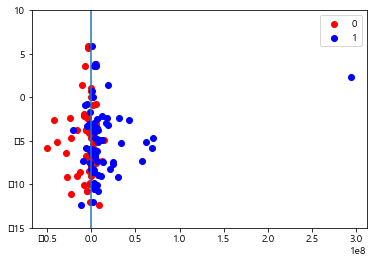

In [161]:
w = train_perceptron(w, x_train, y_train)

print("The weights are:", w)
show_plt(w, x_train, y_train)